In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
with open('LED_OFF_VBMC_LT_RC_VP_DATA_0.pkl', 'rb') as f:
    vp_off = pickle.load(f)

vp_off_samples = vp_off.sample(int(1e6))[0]
V_A_off = np.mean(vp_off_samples[:, 0])
theta_A_off = np.mean(vp_off_samples[:, 1])
t_A_aff_off = np.mean(vp_off_samples[:, 2])

print(f'V_A_off: {V_A_off}, theta_A_off: {theta_A_off}, t_A_aff_off: {t_A_aff_off}')

with open('V_A_step_jump_LED_on_vbmc.pkl', 'rb') as f:
    vp_on = pickle.load(f)

vp_on_samples = vp_on.sample(int(1e6))[0]

base_V_A_on = np.mean(vp_on_samples[:, 0])
new_V_A_on = np.mean(vp_on_samples[:, 1])
theta_A_on = np.mean(vp_on_samples[:, 2])
t_A_aff_on = np.mean(vp_on_samples[:, 3])

print(f'base_V_A_on: {base_V_A_on}, new_V_A_on: {new_V_A_on}, theta_A_on: {theta_A_on}, t_A_aff_on: {t_A_aff_on}')


V_A_off: 1.6137378125198656, theta_A_off: 2.573880466614436, t_A_aff_off: -0.19917020970961555
base_V_A_on: 1.2783394360090388, new_V_A_on: 2.745531612301292, theta_A_on: 1.8736958213181787, t_A_aff_on: 0.020666703803386064


In [4]:
from V_A_step_jump_fit_utils import PDF_hit_V_A_change, CDF_hit_V_A_change, rho_A_t_fn, cum_A_t_fn
T_trunc = 0.3
def on_pdf_fn(t, base_V_A, new_V_A, theta_A, t_A_aff, t_led, trunc_factor, t_stim):   
    # pdf
    if t_led == 0:
        if t <= T_trunc or t >= t_stim:
            pdf = 0
        else:
            trunc_factor = 1 - cum_A_t_fn(T_trunc - t_A_aff, new_V_A, theta_A)
            pdf = rho_A_t_fn(t - t_A_aff, new_V_A, theta_A) / trunc_factor
    else:
        if t <= T_trunc or t >= t_stim:
            pdf = 0
        else:
            pdf = PDF_hit_V_A_change(t - t_A_aff, base_V_A, new_V_A, theta_A, t_led) / trunc_factor
    
    if t > t_stim:
        pdf = 0

    return pdf


def off_pdf_fn(t, t_stim, V_A, theta_A, t_A_aff, T_trunc, trunc_factor):
    """
    PDF(abort / t_stim) that is truncated after T_trunc
    """
    if t <= T_trunc or t >= t_stim:
        pdf = 0
    else:
        pdf = rho_A_t_fn(t - t_A_aff, V_A, theta_A) / trunc_factor

    return pdf


In [5]:
import pandas as pd

# read out_LED.csv as dataframe
og_df = pd.read_csv('../out_LED.csv')

# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

T_trunc = 0.3
print('T_trunc:', T_trunc)

df_led_off = df [ df['LED_trial'] == 0]
df_led_off_trunc_aborts = df_led_off[ (df_led_off['timed_fix'] < df_led_off['intended_fix']) & (df_led_off['timed_fix'] > T_trunc)]
led_off_trunc_aborts = df_led_off_trunc_aborts['timed_fix']
frac_aborts_off = len(led_off_trunc_aborts) / len(df_led_off)


df_led_on = df [ df['LED_trial'] == 1]
df_led_on_trunc_aborts = df_led_on[ (df_led_on['timed_fix'] < df_led_on['intended_fix']) & (df_led_on['timed_fix'] > T_trunc)]
led_on_trunc_aborts = df_led_on_trunc_aborts['timed_fix']
frac_aborts_on = len(led_on_trunc_aborts) / len(df_led_on)

print('frac_aborts_off:', frac_aborts_off)
print('frac_aborts_on:', frac_aborts_on)

ABL: [20 40 60]
ILD: [-16.  -8.  -4.  -2.  -1.   1.   2.   4.   8.  16.]
T_trunc: 0.3
frac_aborts_off: 0.12307854921027996
frac_aborts_on: 0.1515062454077884


In [6]:
bw = 0.01
bins_led = np.arange(-3, 3, bw)
t_pts_led = bins_led[:-1] + bw/2

In [13]:
import random
M = 5000
pdf_on = np.zeros((M, len(t_pts_led)))
pdf_off = np.zeros((M, len(t_pts_led)))
pdf_on_pre_led = np.zeros((M, len(t_pts_led)))

unique_pairs = list(zip(df['intended_fix'], df['intended_fix'] - df['LED_onset_time']))
sampled_pairs = random.sample(unique_pairs, min(M, len(unique_pairs)))

In [14]:
from joblib import Parallel, delayed

def process_pair(idx, t_stim, t_led):
    if t_stim <= t_led:
        print(f' issue at index {idx}')
        return None, None, None, None
    
    trunc_factor_off = 1 - cum_A_t_fn(T_trunc - t_A_aff_off, V_A_off, theta_A_off)
    trunc_factor_on_pre_led = 1 - cum_A_t_fn(T_trunc - t_A_aff_on, base_V_A_on, theta_A_on)

    pdf_on_sample = np.zeros_like(t_pts_led)
    pdf_off_sample = np.zeros_like(t_pts_led)
    pdf_on_pre_led_sample = np.zeros_like(t_pts_led)

    for ti, t in enumerate(t_pts_led):
        trunc_factor_on = 1 - CDF_hit_V_A_change(T_trunc - t_A_aff_on, base_V_A_on, new_V_A_on, theta_A_on, t_led)
        pdf_on_sample[ti] = on_pdf_fn(t + t_led, base_V_A_on, new_V_A_on, theta_A_on, t_A_aff_on, t_led, trunc_factor_on, t_stim)

        pdf_off_sample[ti] = off_pdf_fn(t + t_led, t_stim, V_A_off, theta_A_off, t_A_aff_off, T_trunc, trunc_factor_off)

        pdf_on_pre_led_sample[ti] = off_pdf_fn(t + t_led, t_stim, base_V_A_on, theta_A_on, t_A_aff_on, T_trunc, trunc_factor_on_pre_led)

    
    return idx, pdf_on_sample, pdf_off_sample, pdf_on_pre_led_sample


In [15]:
from tqdm import tqdm
results = Parallel(n_jobs=30)(delayed(process_pair)(idx, t_stim, t_led) for idx, (t_stim, t_led) in tqdm(enumerate(sampled_pairs), total=len(sampled_pairs)))

100%|██████████| 5000/5000 [13:03<00:00,  6.38it/s]


In [18]:
for mi, pdf_on_sample, pdf_off_sample, pdf_on_pre_led_sample in results:
    if mi == None:
        print(f'issue at index {mi}')
        break

    pdf_on[mi, :] = pdf_on_sample
    pdf_off[mi, :] = pdf_off_sample
    pdf_on_pre_led[mi, :] = pdf_on_pre_led_sample


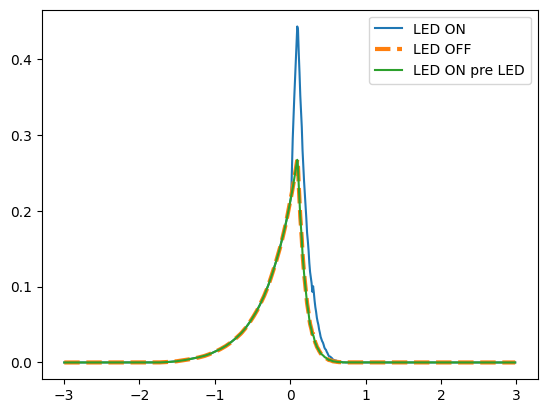

In [21]:
plt.plot(t_pts_led, np.mean(pdf_on, axis=0), label='LED ON')
plt.plot(t_pts_led, np.mean(pdf_off, axis=0), label='LED OFF', ls='--', lw=3)
plt.plot(t_pts_led, np.mean(pdf_on_pre_led, axis=0), label='LED ON pre LED')
plt.legend()